In [1]:
!pip install transformers datasets accelerate
!pip install librosa

In [2]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from datasets import load_dataset, Dataset
import torch
import sklearn
import json, os, time, glob

import numpy as np
import librosa
from collections import defaultdict
from pprint import pprint

from transformers import Trainer

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [3]:
data_path = "16k_data"
glob.glob(data_path + '/**')

['16k_data/meta.json', '16k_data/training_25112024.npz']

In [4]:
arrays = np.load(f'{data_path}/training_25112024.npz')
meta = json.load(open(f'{data_path}/meta.json', 'r'))

pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


## Data augmentation

In [5]:
# Beispiel für Data Augmentation auf einem Audiodatensatz
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio)) * noise_factor
    augmented_audio = audio + noise
    return np.clip(augmented_audio, -1.0, 1.0)  # Clips the audio between -1 and 1

def pitch_shift(audio, sr, shift=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate=rate)

# Beispiel eines Augmentierungsprozesses
def augment_audio(audio, sr):
    augmentation_type = random.choice(['noise', 'pitch', 'stretch'])
    
    if augmentation_type == 'noise':
        return add_noise(audio)
    elif augmentation_type == 'pitch':
        return pitch_shift(audio, sr)
    elif augmentation_type == 'stretch':
        return time_stretch(audio)
    
    return audio


## Model

In [6]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

In [30]:
import numpy as np
import torch
from datasets import Dataset

def process_and_augment_dataset(arrays, meta, feature_extractor, n_augments=5):
    augmented_audio_data = []
    augmented_labels = []
    
    sr = meta['sample_rate']
    
    for i, audio in enumerate(arrays['X']):
        label = arrays['y'][i]
        
        # Originale Daten hinzufügen
        preprocessed_audio = feature_extractor(
            audio,
            sampling_rate=sr,
            return_tensors="pt"
        )
        augmented_audio_data.append(preprocessed_audio['input_values'])
        augmented_labels.append(label)  # Originales Label
        
        # Augmentierung nur für Labels 1 und 2
        if label in [1, 2]:
            for _ in range(n_augments):
                # Augmentierung auf rohen Audiodaten anwenden
                augmented_audio = augment_audio(audio, sr)
                
                # Feature-Extraktion nach der Augmentierung
                preprocessed_audio = feature_extractor(
                    augmented_audio,
                    sampling_rate=sr,
                    return_tensors="pt"
                )
                
                augmented_audio_data.append(preprocessed_audio['input_values'])
                augmented_labels.append(label)  # Augmentiertes Label
    
    # Alle augmentierten Eingabewerte kombinieren
    input_values = torch.cat(augmented_audio_data, dim=0)
    
    hf_dataset = Dataset.from_dict({
        "input_values": input_values.numpy(),  # In NumPy-Array umwandeln
        "label": np.array(augmented_labels)  # Labels als NumPy-Array
    })

    return hf_dataset

hf_dataset = process_and_augment_dataset(arrays, meta, feature_extractor, 1) 
# bei <1 entstehen eventuell duplikate

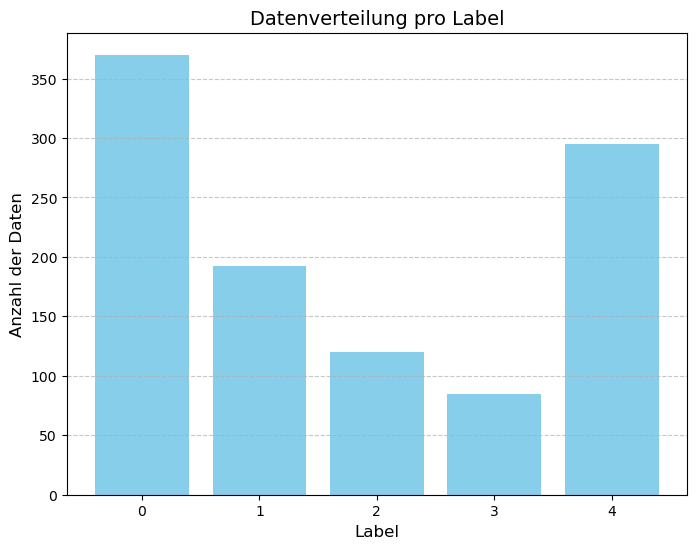

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(hf_dataset):
    # Labels aus dem Dataset extrahieren
    labels = hf_dataset["label"]
    
    # Häufigkeit der Labels zählen
    label_counts = Counter(labels)
    
    # Balkendiagramm erstellen
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Anzahl der Daten", fontsize=12)
    plt.title("Datenverteilung pro Label", fontsize=14)
    plt.xticks(ticks=list(label_counts.keys()), labels=list(label_counts.keys()), fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot erstellen
plot_label_distribution(hf_dataset)


In [ ]:
# preprocessed_audio = feature_extractor(
#     arrays['X'],
#     sampling_rate = meta['sample_rate'],
#     return_tensors = "pt"
# )

# hf_dataset = Dataset.from_dict({
#     "input_values": preprocessed_audio['input_values'],
#     "label": arrays['y'],
# })

In [34]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [35]:
import transformers

batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [36]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [37]:
train_ds = hf_dataset.select(train_index)

In [38]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [39]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y= hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.5741, 1.1063, 1.7700, 2.4988, 0.7200], device='cuda:0')


In [40]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [43]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.648700,1.630611,0.301310,0.174970,0.184870
20,1.031300,1.058728,0.593886,0.579823,0.576967
30,0.552700,0.786584,0.751092,0.716239,0.755752
40,0.453200,0.830519,0.655022,0.659264,0.658950
50,0.309300,0.789892,0.676856,0.671662,0.682555
60,0.245600,0.671905,0.755459,0.734913,0.758874
70,0.207800,0.798124,0.655022,0.647139,0.653427
80,0.172400,0.720208,0.724891,0.702282,0.725880
90,0.128200,0.688057,0.742358,0.727857,0.748660
100,0.101500,0.707015,0.733624,0.721559,0.742568


TrainOutput(global_step=105, training_loss=0.46819208008902413, metrics={'train_runtime': 449.4995, 'train_samples_per_second': 7.531, 'train_steps_per_second': 0.234, 'total_flos': 2.2043569543446528e+17, 'train_loss': 0.46819208008902413, 'epoch': 4.8})

In [44]:
pred = trainer.predict(hf_dataset.select(test_index))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        60
           1       0.38      0.65      0.48        26
           2       0.87      0.59      0.70        78
           3       0.71      0.73      0.72        33
           4       0.75      0.94      0.83        32

    accuracy                           0.73       229
   macro avg       0.72      0.75      0.72       229
weighted avg       0.78      0.73      0.74       229



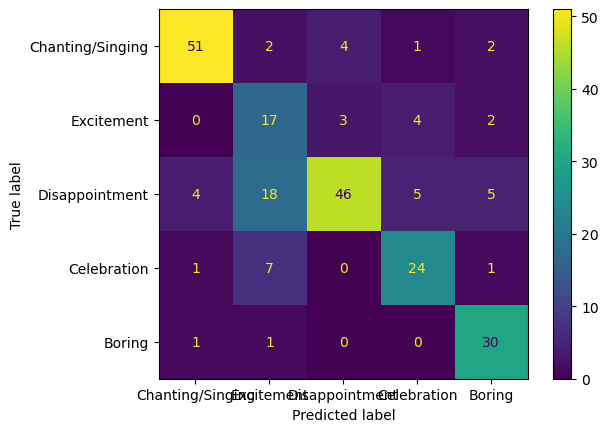

In [45]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot()

print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [46]:
id2label = {v:k for k,v in meta['labels'].items()}

In [47]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        60
           1       0.38      0.65      0.48        26
           2       0.87      0.59      0.70        78
           3       0.71      0.73      0.72        33
           4       0.75      0.94      0.83        32

    accuracy                           0.73       229
   macro avg       0.72      0.75      0.72       229
weighted avg       0.78      0.73      0.74       229



In [48]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

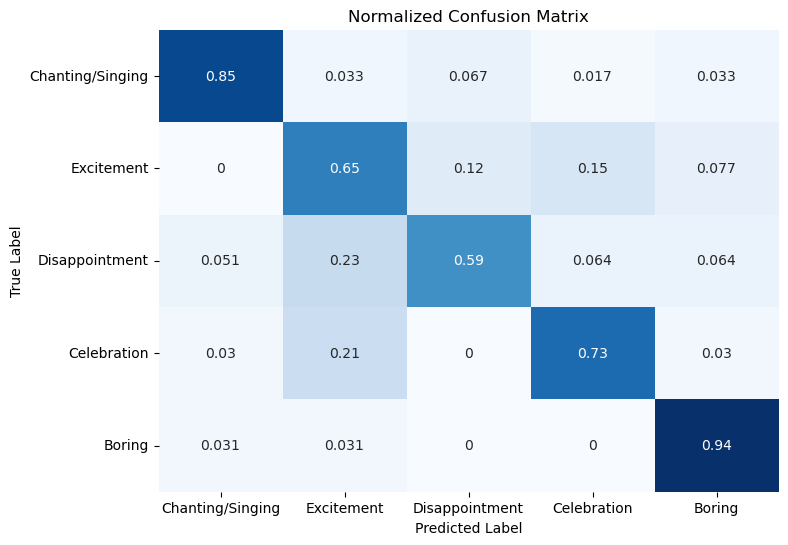

In [49]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()